Notebook by:

* Lorenzo Pannacci 1948926
* ADD YOUR NAME

## Startup

In [ ]:
######################
# LIBRARIES DOWNLOAD #
######################

install_packages = True
if install_packages:
    %pip install numpy pandas

In [ ]:
####################
# LIBRARIES IMPORT #
####################

import numpy as np
import pandas as pd

## 1. Recommendation sytem 

Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user. 

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user. 

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.

In [ ]:
# TODO

### 1.2 Minhash Signatures

Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket. 

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

In [ ]:
# TODO

### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at __most five movies__ to the user to watch based on the movies clicked by similar users. 

To recommend at most five movies given a user_id, use the following procedure: 

1. Identify the <ins>two most similar</ins> users to this user.
2. If these two users have any movies __in common__, recommend those movies based on the total number of clicks by these users.
3. If there are __no more common__ movies, try to propose the most clicked movies by the __most similar user first__, followed by the other user. 

__Note:__ At the end of the process, we expect to see at most five movies recommended to the user.

__Example:__ assume you've identified user __A__ and __B__ as the most similar users to a single user, and we have the following records on these users: 

- User A with 80% similarity
- User B with 50% similarity
  
|user|movie title|#clicks|
|---|---|---|
|A|Wild Child|20|
|A|Innocence|10|
|A|Coin Heist|2|
|B|Innocence|30|
|B|Coin Heist|15|
|B|Before I Fall|30|
|B|Beyond Skyline|8|
|B|The Amazing Spider-Man|5|

- __Recommended movies__ in order:
    - Innocence
    - Coin Heist
    - Wild Child
    - Before I Fall
    - Beyond Skyline

In [ ]:
# TODO

## 2. Grouping Users together!

Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering

1)  Access to the data found in [this dataset](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies)

2)  Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as *feature engineering*. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features **for each** user:

    a)  Favorite genre (i.e., the genre on which the user spent the most time)

    b)  Average click duration

    c)  Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

    d)  Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

    e)  Average time spent a day by the user (considering only the days he logs in)

So, in the end, you should have for each user_id five features.

3)  Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

In [ ]:
# TODO

### 2.2 Choose your features (variables)!

You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

1)  *To normalise or not to normalise? That's the question*. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the `scikit-learn` library).

2)  Select **one** method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

In [ ]:
# TODO

### 2.3 Clustering!

1)  Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2)  Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3)  Run the algorithm on the data obtained from the dimensionality reduction.

4)  Implement **K-means++** from scratch and explain the differences with the results you got earlier.

5)  Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [ ]:
# TODO

### 2.4 Analysing your results!

You are often encouraged to explain the main characteristics that your clusters have. The latter is called the *Characterizing Clusters* step. Thus, follow the next steps to do it:

1)  Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

2)  Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories.

3)  With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.

4)  Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

5)  Interpret the results for each pivot table.

6)  Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

In [ ]:
# TODO

## 3. Bonus Question

We remind you that we consider and grade the bonuses only if you complete the entire assignment.

[Density-based clustering](https://wires.onlinelibrary.wiley.com/doi/epdf/10.1002/widm.30) identifies clusters as regions in the data space with high point density that are separated from other clusters by regions of low point density. The data points in the separating regions of low point density are typically considered noise or outliers. Typical algorithms that fall into this category are [OPTICS](https://dl.acm.org/doi/pdf/10.1145/304181.304187) and [DBSCAN](https://cdn.aaai.org/KDD/1996/KDD96-037.pdf).

1)  Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results: how different are they from the centroid-based version?

__Note__: You can implement your algorithm from scratch or use the one implemented in the scikit-learn library; the choice is up to you!

In [ ]:
# TODO

## 4. Command Line Question

In this exercise, we were asked to answer the following questions using only command line tools:

- Q1) What is the most-watched Netflix title? 

    To answer this question, we counted the number of occurrences of each title and returned the one with the highest frequency. We chose not to consider the actual time spent watching each title as a comparison parameter because we believed that this criterion could have skewed the result due to the heterogeneity of the durations of the various films.

- Q2) Report the average time between subsequent clicks on Netflix.com

    To answer this question, we first sorted the dataset chronologically by clicks, ordering the `datetime` column in ascending order. Subsequently, we calculated the time elapsed between one click and the next one, and finally we took the average of these differences.

- Q3) Provide the ID of the user that has spent the most time on Netflix

    To address this question, we first grouped the rows of the dataset for each individual user identified through the `user_id` column. Then, we obtained the total time spent on Netflix cumulating the `duration` column for each user. Finally, we returned the ID with the maximum value of this sum. 


The results of these queries are displayed in the screenshot below, while the code used can be found in the `CommandLine.sh` file in the repository. The file contains comprehensive comments explaining its functionality. Of course, the file is executable, and the results are reproducible if the following steps are followed:

1. The `CommandLine.sh` file and the dataset need to be placed in the same folder;

2. You must navigate to the folder containing the two files using the terminal;

3. You need to enable the execution permissions for the file by running the following code $\to$ `chmod +x CommandLine.sh`

4. Finally, you can execute the file using the following command $\to$ `./CommandLine.sh`

**ATTENTION**

This bash script utilizes the `mktime` function, which is not natively present in the `awk` command of the macOS operating systems. Therefore, to make the file executable, it is necessary to install the `gawk` command, which is an extended and enhanced version of the previous command. To do so, you need to use a package manager for macOS, such as `Homebrew`, which can be installed by running the following command in the terminal:

`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

This command can also be directly copied from the Homebrew website, which can be accessed through this [link](https://brew.sh/).

Once this is done, you can install the gawk command by executing the following command in the terminal:

`brew install gawk`

This command and function should already be natively supported by the Windows operating system so, on such devices, no additional measures are required beyond those already outlined in points 1-2-3-4.


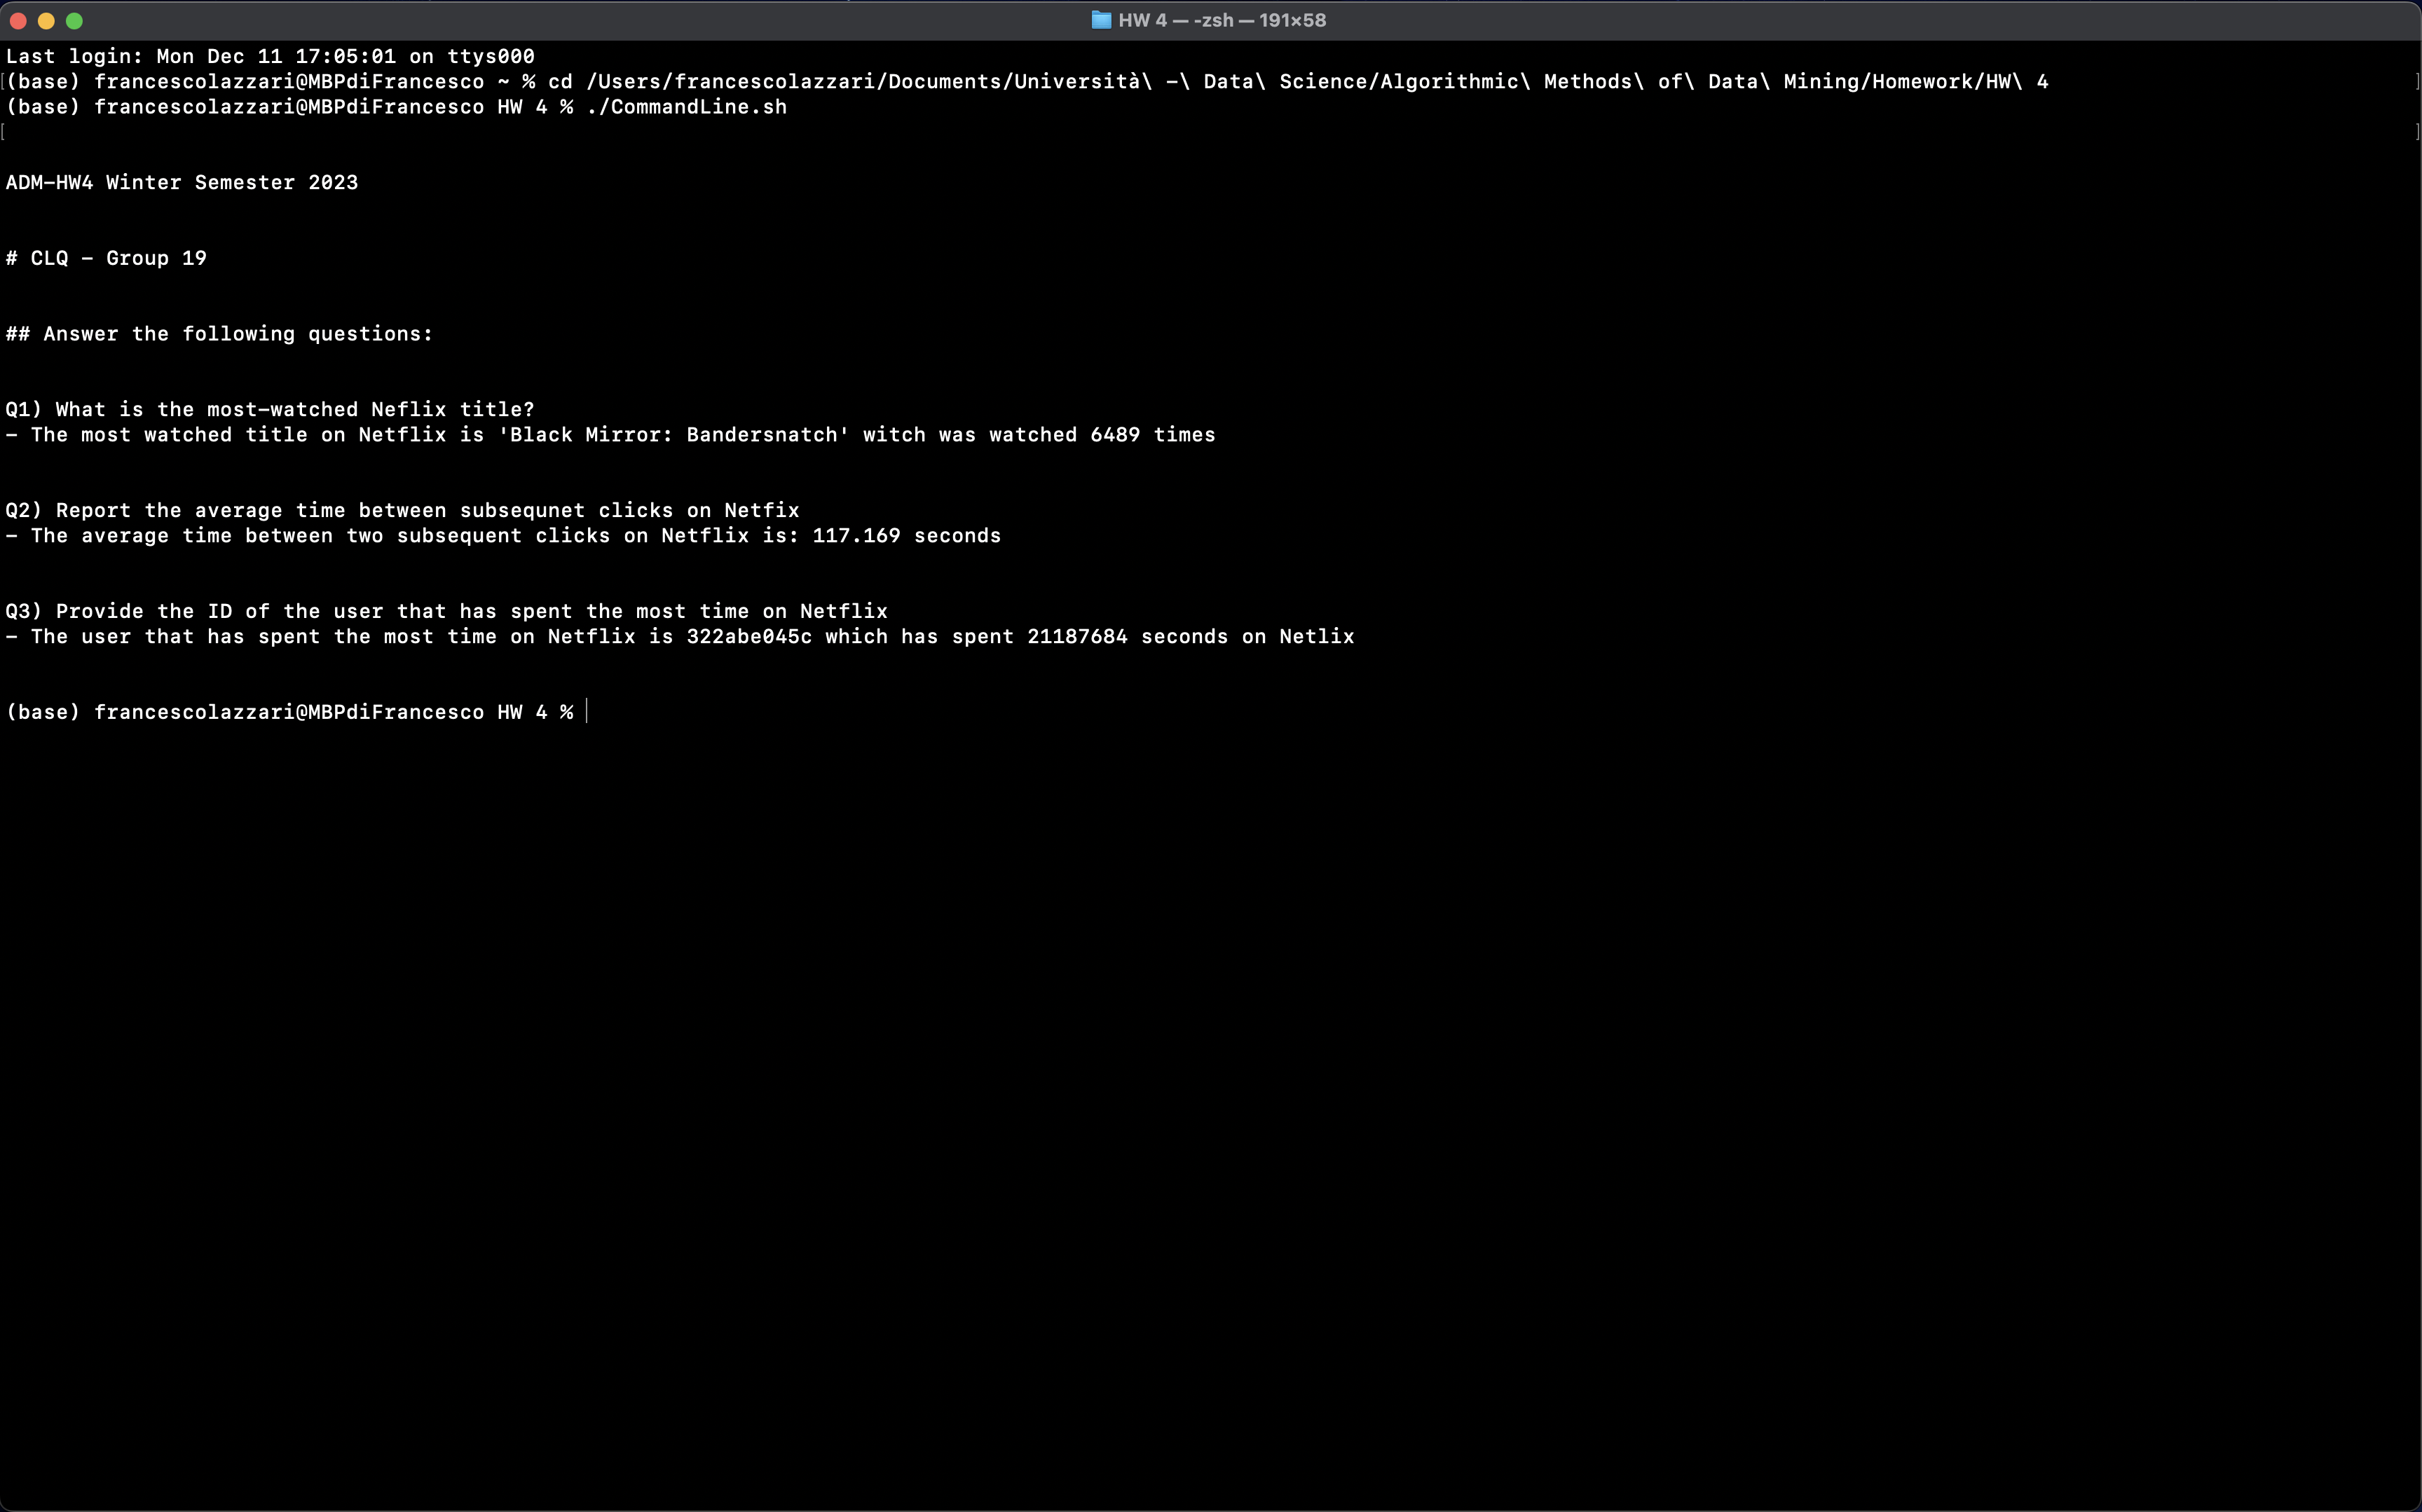


## 5. Algorithmic Question 

Federico studies in a demanding university where he has to take a certain number $N$ of exams to graduate,  but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system. 

He was given an initial personal score of $S$ when he enrolled, which changes every time he takes an exam: now comes the crazy part.
He soon discovered that every of the $N$ exams he has to take is assigned a mark $p$. Once he has chosen an exam, his score becomes equal to the mark $p$, and at the same time, the scoring system changes:
+ If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity $S - p$.
+ If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity $p - S$.
  
So, for example, consider $S=8$ as the initial personal score. Federico must decide which exam he wants to take, being $[5,7,1]$ the marks list. If he takes the first one, being $5 < 8$ and $8 - 5 = 3$, the remaining list now becomes $[10,4]$, and his score is updated as $S = 5$.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line,  and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get. 

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on
because he wants to do paid counseling for other desperate students: in a *recursive* fashion, the helped helps the helpable.

b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university! 

c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. 
You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

Here are some input/output examples (the first value is the initial personal score, and the second line contains the list of marks): 

__Input 1__
```
8
5 7 1 
```

__Output 1__
```
11
```

__Input 2__
```
25
18 24 21 32 27
```

__Output 2__
```
44
```

__Input 3__
```
30
13 27 41 59 28 33 39 19 52 48 55 79
```

__Output 3__
```
109
```

In [ ]:
# TODO